# The gradient of Antarctic Ice Sheet

As an aside, in this section we use the concept of gradient introduced on the previous page to compute the slope of the Antarctic Ice SHeet using some surface elevation data.

In this section we will:
- load the bedmachine dataset from a version stored in the cloud
- computes the surface gradient in the $x$ and $y$ directions
- computes the slope from these two components


## 1. Import packages 
We will import packages required  for 
opening the data (fsspec), 
doing computations (numpy), 
storing the data and results in memory and plotting them (xarray), and plotting with interactive features (hvplot.xarray).

In [2]:
import fsspec
import numpy as np
import xarray as xr
import hvplot.xarray


## 2. Lazily load the data
First we get a 'mapper' which points to the data in cloud storage, then we lazily load it in to a multi-dimensional array called an xarray, which we cam bm.

In [3]:
bm_mapper = fsspec.get_mapper('gs://ldeo-glaciology/bedmachine/bm.zarr', mode='ab')
bm = xr.open_zarr(bm_mapper)  

Let's take a look at the xarray we get from the cell above

In [4]:
bm

<xarray.Dataset>
Dimensions:    (y: 13333, x: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    bed        (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    mask       (y, x) int8 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
Attributes: (12/25)
    Author:                                 Mathieu Morlighem
    Conventions:                            CF-1.7
    Data_citation:                          Morlighem M. et al., (2019), Deep...
    Notes:                                  Data processed at the Department ...
    Projection:                             Polar Stereographic South (71S,0E)
    Title:                                  BedMachine Antarctica
    ...                                     ...
    spacing:                                [500]
    standard_parallel:                      [-71.0]
    straight_vertical_longitude_from_pole:  [0.0]
    version:                                05-Nov-2019 (v1.38)
    xmin:                                   [-3333000]
    ymax:                                   [3333000]

## 3. Compute the two components of the gradient 
We will use the numpy function `numpy.gradient`
The second argument is the grid spacing, which is the same in both directions in this case. It is stored in the attributes of the xarray (and were loaded from the zarr in cloud storage). 

In [6]:
dhdy, dhdx = np.gradient(bm.surface.values,bm.attrs['nx'][0])

 ## 4. Compute the slope by taking the pythagorean sum of the two components.

$$ 
S =  \sqrt{\left(\frac{\partial h}{\partial x}\right)^2 + \left(\frac{\partial h}{\partial y}\right)^2}
$$

and add this to the xarray as a new field. Also define a name and units for the new field. 

In [8]:
slope = xr.zeros_like(bm.thickness)
slope.values = np.sqrt(dhdy**2 + dhdx**2)
bm['slope'] = slope
bm.slope.attrs['long_name'] = 'ice surface slope'
bm.slope.attrs['units'] = '-'

## 5. Plotting
Let's plot a subset of the slopes to examine the orderof magnitude of the slopes.

In [9]:
subset_of_slope = bm.slope.isel(x = slice(2000,3000), y = slice(4000,5000))

options = dict(x = 'x', y = 'y', clim = (0, 0.001), width = 800, height = 800, cmap = 'viridis')

subset_of_slope.hvplot(**options);

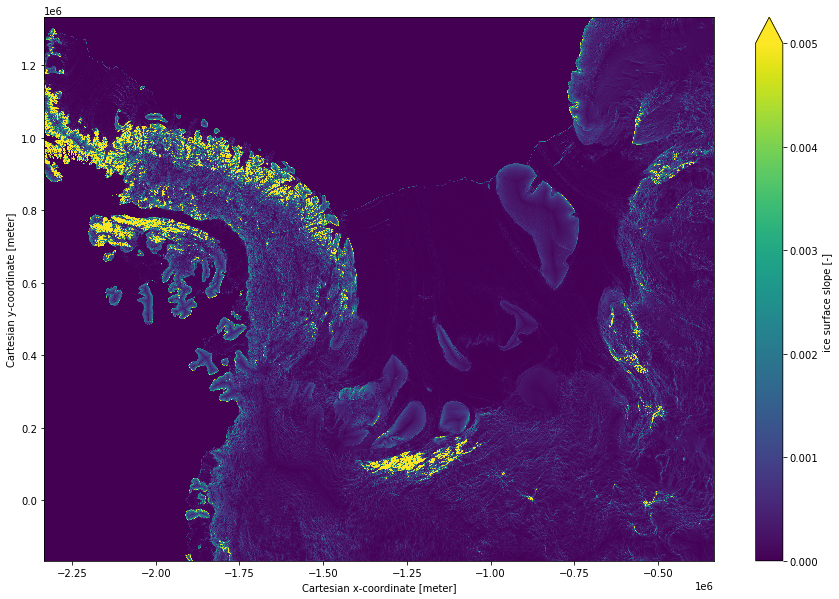

In [10]:
bm.slope.isel(x = slice(2000,6000), y = slice(4000,7000)).plot(vmin = 0, vmax = 0.005, size = 10);

In [7]:
all_slope_coarse = bm.slope.coarsen(x=5,y=5,boundary='trim').mean().persist()
options = dict(x='x', y='y', clim=(0, 0.001), width=800, height=800, cmap='viridis')
all_slope_coarse.hvplot(**options)

:Image   [y,x]   (grad)